# <center>Advanced Radiation Mitigation for Orbital Reliability</center>

This notebook contains a python script that open an external window (see below) divided in six panels. The user can defined the orbit's parameters in panel 4 an see it in the panel 1 as the impact of the trajectory on the received radiation per orbit in panel 2.
The characteristics of the satellite, mainly its shielding (material and thickness) can be set by the user in panel 6. More details on how to use this App in the User_Manual.pdf

**<span style="color:red">To close the window you need to restart the kernel (without running the cells).</span>**

<img src="./Screenshot_App.png" alt="ScreenShot App"/>

---

---
## DO NOT MODIFY ANYTHING BELOW (exception for developpers)


In [1]:
# Import required libraries
import tkinter as tk
from tkinter import ttk
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.lines as Lines
import numpy as np
import scipy.integrate as integrate
import math

In [2]:
# DEBUG
import time

---
## Defining material properties

In [3]:
# Make a ditionary containing the possible material for shielding and their relevant properties as the density, mu/rho factor, price and Stopping Power
# New materials can be added in this dictionnary. NOTE : a new RadioButton should be added manually with the others material button (~ cell [64])
material_params = {
"None":{
    "rho":0., # kg.m-3
    "muorho":0.0, # m2/kg
    "price_perKg":0.0,
    "StopPower_sol":np.nan,
    "StopPower_proton":np.nan,
    "StopPower_elec":np.nan
    },
"Aluminium":{
    "rho":2700., # kg.m-3
    "muorho":0.02, # m2/kg
    "price_perKg":2.6, # Around 2600$/t from https://tradingeconomics.com/commodity/aluminum
    "StopPower_sol":5.678, # https://physics.nist.gov/cgi-bin/Star/ap_table.pl (only protons of E = 100 MeV)
    "StopPower_proton":33.76, # https://physics.nist.gov/cgi-bin/Star/ap_table.pl
    "StopPower_elec":1.604 # https://physics.nist.gov/cgi-bin/Star/e_table.pl
    },
"Polyethylene":{
    "rho":940., # kg.m-3
    "muorho":0.08, # m2/kg
    "price_perKg":8.3, # Around 8300$/t from https://tradingeconomics.com/commodity/polyethylene
    "StopPower_sol":7.746, # https://physics.nist.gov/cgi-bin/Star/ap_table.pl (only protons of E = 100 MeV)
    "StopPower_proton":49.26, # https://physics.nist.gov/cgi-bin/Star/ap_table.pl
    "StopPower_elec":2.147 # https://physics.nist.gov/cgi-bin/Star/e_table.pl
    },
"Composite":{
    "rho":1600., # kg.m-3
    "muorho":0.05, #m2/kg
    "price_perKg":885., # 6 1mx1mx1mm plates of carbon fiber cost ~1240$
    "StopPower_sol":np.nan,
    "StopPower_proton":np.nan,
    "StopPower_elec":np.nan
    },
"Satellite":{
    "rho":2110., # kg.m-3 # Composition 50% Aluminium, 30% Composite, 20% Electronics
    "muorho":0.041, #m2/kg Typical value from materials forming the satellite (without shielding)
    "price_perKg":np.nan, # should not be used
    "StopPower_sol":5.678, # Same as Aluminium
    "StopPower_proton":33.76, # Same as Aluminium
    "StopPower_elec":1.604 # Same as Aluminium
    }
}

---
## Defining functions

In [4]:
def torus(R, r):
    """
    Function that define a Torus surface

    Args:
        R (float): radial position of the center of the Torus
        r (float): radius of the Torus

    Returns:
        X (array): x-position defining the surface of the Torus
        Y (array): y-position defining the surface of the Torus
        Z (array): z-position defining the surface of the Torus
    
    """
    
    phi = np.linspace(0, 2*np.pi, 30)  # Angle azimutal
    theta = np.linspace(-np.pi/2, np.pi/2, 10)  # Angle polaire
    phi, theta = np.meshgrid(phi, theta)
    X = (R + r * np.cos(theta)) * np.cos(phi)
    Y = (R + r * np.cos(theta)) * np.sin(phi)
    Z = r * np.sin(theta)
    return X, Y, Z

In [5]:
def isInTorus(x, y, z, R_c, r_t):
    """
    Function that check if a 3D position is inside a Torus

    Args:
        x (array): x-position
        y (array): y-position
        z (array): z-position 
        R_c (float): radial position of the center of the Torus
        r_t (float): radius of the Torus

    Returns:
        in_torus (bool): is the position inside the Torus 
    
    """
    
    # Radial projection distance onto XY plane
    r_dist = np.sqrt(x*x + y*y)

    # First condition: radial distance to torus center
    cond_radial = np.abs(r_dist - R_c) <= r_t

    # Second condition: vertical thickness
    cond_vertical = np.abs(z) <= r_t

    # Combine conditions element-wise with &
    in_torus = cond_radial & cond_vertical
    
    return in_torus

In [6]:
def compute_time_in_van_allen():
    """
    Function that compute the time passed during one orbit inside the Val Allen Belts

    Args:

    Returns:
        time_inner (array): time array in seconds flagging the passage of the orbit in the inner Van Allen belt
        time_outer (array): time array in seconds flagging the passage of the orbit in the outer Van Allen belt
        dt         (array): time step array for integration
    
    """

    # Get orbital parameters from the sliders
    a = get_converted_slider_value("Semi-major axis") * 1.e3  # Convert in meters
    e = get_converted_slider_value("Eccentricity")
    mu = 3.986e14  # Earth's gravitational constant (m³/s²)

    # Specific angular Momentum
    h = np.sqrt(mu * a * (1 - e**2))
    
    
    time_inner = np.zeros(len(x))
    time_outer = np.zeros(len(x))
    dt         = np.zeros(len(x))

    theta_values = np.linspace(0, 2 * np.pi, len(x))
    for i in range(len(theta_values)-1):
        theta = theta_values[i]

        # orbital radius at theta_value
        r = (a * (1 - e**2)) / (1 + e * np.cos(theta))

        # orbital velocity
        v = np.sqrt(mu * (2/r - 1/a))

        # time between two points (2nd kepler Law)
        dt[i] = (r**2 / h) * (theta_values[i+1] - theta_values[i])

        # Check if the sattelite is in one Van Allen belt
        if isInTorus(x[i], y[i], z[i], Rcenter_inner, Radius_inner):
            time_inner[i] = 1.
        elif isInTorus(x[i], y[i], z[i], Rcenter_outer, Radius_outer):
            time_outer[i] = 1.
    return time_inner, time_outer, dt

In [7]:
def compute_fluence_van_allen(year=None):
    """
    Compute fluence inside Van Allen Belts

    Args:


    Returns:
        fluence_inner (array): Fluence in particles/cm²/s in the inner Van Allen Belt along the orbit
        fluence_outer (array): Fluence in particles/cm²/s in the outer Van Allen Belt along the orbit
    """
    
    # get radius array
    rcyl = np.sqrt(x**2+y**2)
    
    # Ref Fluence from Mauk 2013
    fluence_inner_ref = 2.0e5 # particles/cm²/s
    fluence_outer_ref = 1.0e6 # particles/cm²/s
    
    fluence_inner = fluence_inner_ref * np.exp(-(rcyl-Rcenter_inner)**2/(2.*Radius_inner**2))  
    fluence_outer = fluence_outer_ref * np.exp(-(rcyl-Rcenter_outer)**2/(2.*Radius_outer**2))

    if (year!=None):
        modulation = 1. #+ 0.5 * np.sin(2 * np.pi \exp/ 11 * (year-5.5/2.)) # Find good parametrization
        fluence_inner*=modulation
        fluence_outer*=modulation

    return fluence_inner, fluence_outer

In [8]:
def update_basicslabels(event=None):
    """
    Function which update all the labelsin the information panelsby calling the relevent update functions
    This function is called when the mouse's left button is realeased inside the App window

    Args:


    Returns:

    """

    print_Period()
    printTotalMassCost()

In [9]:
def update_labels(event=None):
    """
    Function which update all the labelsin the information panelsby calling the relevent update functions
    This function is called when the mouse's left button is realeased inside the App window

    Args:


    Returns:

    """

    printTIDperOrbit()
    printDDperOrbit()

In [10]:
def update_basicgraphs(event=None):
    """
    Function which update all the basic panels and text by calling the relevent update functions
    This function is called when the mouse's left button is realeased inside the App window

    Args:


    Returns:

    """
    
    update_orbit()
    update_solar_flux()

In [11]:
def update_all(event=None):
    """
    Function which update all the panels and text including the panel 3 which take some time to be computed
    This function is called when the left clik of the mouse is released from a slider or after entering an entry

    Args:


    Returns:

    """

    update_basicslabels()
    update_labels()
    update_basicgraphs()
    update_tid_DD()

In [12]:
def plot_3DObjects():
    """
    Function which plot the Earth and the Val Allen Belts + an empty orbit in the 3D plot in panel 1

    Args:

    Returns:
        A nice plot !
        
    """

    # Parameters Van Allen Belts
    global R_earth, Radius_inner, Rcenter_inner, Radius_outer, Rcenter_outer
    R_earth = 6371.
    
    # Inner Belt # Li and Hudson 2019
    Rcenter_inner = 1.5*R_earth
    rinner_min = 1.3*R_earth
    rinner_max = 1.7*R_earth
    Radius_inner = 0.2*R_earth
    
    X_inner, Y_inner, Z_inner = torus(Rcenter_inner, Radius_inner)
    ax_orbit.plot_surface(X_inner, Y_inner, Z_inner, color='red', alpha=0.6)
    ax_orbit.scatter(1e18, 1e18, 1e18, color='red', alpha=0.6, lw=4, label='Inner Van Allen Belt')

    # outer belt # Li and Hudson 2019
    Rcenter_outer = 4.*R_earth
    router_min = 3.*R_earth
    router_max = 5.*R_earth
    Radius_outer = 1.*R_earth
    
    X_outer, Y_outer, Z_outer = torus(Rcenter_outer, Radius_outer)
    ax_orbit.plot_surface(X_outer, Y_outer, Z_outer, color='green', alpha=0.3)
    ax_orbit.scatter(1e18, 1e18, 1e18, color='green', alpha=0.3, lw=4, label='Outer Van Allen Belt')
    

    thetae = np.linspace(0, 2*np.pi, 30) 
    phie = np.linspace(0, np.pi, 30)
    thetae, phie = np.meshgrid(thetae, phie)

    # Earth coordinate
    x_earth = R_earth * np.cos(thetae) * np.sin(phie)
    y_earth = R_earth * np.sin(thetae) * np.sin(phie)
    z_earth = R_earth * np.cos(phie)
    ax_orbit.plot_surface(x_earth, y_earth, z_earth, color='b', alpha=0.7)
    
    
    # Highlight South Atlantic Anomaly
    R_SSA = 5000.
    x_ssa = R_SSA * np.cos(thetae) * np.sin(phie) + 4783.6
    y_ssa = R_SSA * np.sin(thetae) * np.sin(phie) - 4014.7
    z_ssa = R_SSA * np.cos(phie) - 3185.5
    ax_orbit.plot_surface(x_ssa, y_ssa, z_ssa, color='purple', alpha=0.5)
    ax_orbit.scatter(1e18, 1e18, 1e18, color='purple', label='SAA', s=20, alpha=0.5)

    # Empty orbit
    global orbit_line
    orbit_line, = ax_orbit.plot([], [], [], label='Satellite Orbit', color="black", linewidth=2)

    
    ax_orbit.legend(loc='upper left')
    ax_orbit.set_xlabel('X (km)')
    ax_orbit.set_ylabel('Y (km)')
    ax_orbit.set_zlabel('Z (km)')
    ax_orbit.set_title('3D Orbit Visualization', fontsize=16)
    coord_max = 40000.
    ax_orbit.set_xlim(-coord_max, coord_max)
    ax_orbit.set_ylim(-coord_max, coord_max)
    ax_orbit.set_zlim(-coord_max, coord_max)

In [13]:
def plot_orbit(a=19300, e=0.25, i=45., Omega=90., omega=90.):
    """
    Function which plot the orbit of the satellite, the Earth and the Val Allen Belts in the 3D plot in panel 1. 

    Args:
        a (float): semi-major axis in km
        e (float): eccentricity
        i (float): inclination of the orbit in degree
        Omega (float): longitude of the ascending node of the orbit in degree
        omega (float): argument of periastron of the orbit in degree

    Returns:
        A nice plot !

    """
       
    global x, y, z
    i_rad = np.radians(i)
    Omega_rad = np.radians(Omega)
    omega_rad = np.radians(omega)
    # Example orbit (elliptical)
    f = np.linspace(0, 2 * np.pi, 100)
    r = a * (1 - e**2) / (1 + e * np.cos(f))

    # Cordinate in the orbital plane
    x_prime = r * np.cos(f)
    y_prime = r * np.sin(f)
    z_prime = 0

    # Rotation by the argument of periastron (omega)
    x_double_prime = x_prime * np.cos(omega_rad) - y_prime * np.sin(omega_rad)
    y_double_prime = x_prime * np.sin(omega_rad) + y_prime * np.cos(omega_rad)
    z_double_prime = z_prime

    # Rotation by inclination (i)
    x_triple_prime = x_double_prime
    y_triple_prime = y_double_prime * np.cos(i_rad)
    z_triple_prime = y_double_prime * np.sin(i_rad)

    # Rotation by the longitude of the ascending node (Omega)
    x = x_triple_prime * np.cos(Omega_rad) - y_triple_prime * np.sin(Omega_rad)
    y = x_triple_prime * np.sin(Omega_rad) + y_triple_prime * np.cos(Omega_rad)
    z = z_triple_prime 
    

In [14]:
def update_orbit(event=None):
    """
    Update the plot of the orbit from the parameters of the sliders

    Args:
        event (tkinter event): event that trigerred the function

    Returns:
        
    """

    t0 = time.perf_counter() # DEBUG
    
    a = get_converted_slider_value("Semi-major axis")
    e = get_converted_slider_value("Eccentricity")
    i = get_converted_slider_value("Inclination")
    Omega = get_converted_slider_value("Longitude of ascending node")
    omega = get_converted_slider_value("Argument of periapsis")
    plot_orbit(a=a, e=e, i=i, Omega=Omega, omega=omega)
    
    orbit_line.set_data(x, y)
    orbit_line.set_3d_properties(z)
    fig_orbit.canvas.draw_idle()
    #fig_orbit.canvas.restore_region(orbit_bg)
    #ax_orbit.draw_artist(orbit_line)
    #fig_orbit.canvas.blit(fig_orbit.bbox)

    
    t1 = time.perf_counter() #DEBUG
    print(f"[update_orbit] execution time = {(t1 - t0)*1000:.2f} ms") #DEBUG

In [15]:
def get_converted_slider_value(param):
    """
    Get converted value from the sliders

    Args:
        param (string): name of the parameter to get the converted value

    Returns:
        (float): converted value
    """
    
    if (param == "Semi-major axis"):
        return 6800. + param_sliders[param]["slider"].get()/100.*5.e4
    elif (param == "Eccentricity"):
        if (param_sliders[param]["slider"].get()==100.):
            return 0.9999
        return param_sliders[param]["slider"].get()/100.
    elif (param == "Inclination"):
        return param_sliders[param]["slider"].get()*180./100.
    elif (param == "Longitude of ascending node"):
        return param_sliders[param]["slider"].get()*360./100.
    elif (param == "Argument of periapsis"):
        return param_sliders[param]["slider"].get()*360./100.
    elif (param == "Solar Activity Phase"):
        return param_sliders[param]["slider"].get()/100.*11.

In [16]:
def get_value_for_slider(param):
    """
    Set the value for the sliders from the entry

    Args:
        param (string): name of the parameter to set the slider value

    Returns:
        (float): slider value
    """
    
    if (param == "Semi-major axis"):
        return (float(param_sliders[param]["entry"].get())-6800.)/4.e4*100.
    elif (param == "Eccentricity"):
        if (param_sliders[param]["entry"].get()==1.):
            return 99.99
        return float(param_sliders[param]["entry"].get())*100.
    elif (param == "Inclination"):
        return float(param_sliders[param]["entry"].get())/180.*100.
    elif (param == "Longitude of ascending node"):
        return float(param_sliders[param]["entry"].get())/360.*100.
    elif (param == "Argument of periapsis"):
        return float(param_sliders[param]["entry"].get())/360.*100.
    elif (param == "Solar Activity Phase"):
        return float(param_sliders[param]["entry"].get())*100./11.

In [17]:
def print_Period(event=None):
    """
    Update the orbital Period Label in Panel 4

    Args:
        event (tkinter event): event that trigerred the function

    Returns:
    
    """
    
    a = get_converted_slider_value("Semi-major axis")
    P_sec = 2.*np.pi*np.sqrt((a*1.e3)**3/(6.67430e-11*5.972e24))
    P_min = P_sec/60.
    P_hour = P_min/60.
    P_day = P_hour/24.
    # Check value for an appropriate format (in minutes, hours or days) 
    if P_day>1.0:
        Period_label.config(text=f"Orbital period P = {P_day:.2f} day(s)")
    elif P_hour>1.0:
        Period_label.config(text=f"Orbital period P = {P_hour:.2f} hour(s)")
    elif P_min>1.0:
        Period_label.config(text=f"Orbital period P = {P_min:.2f} minute(s)")
    else:
        Period_label.config(text=f"Orbital period P = {P_sec:.2f} second(s)")

In [18]:
def plot_solar_flux(x=2.75):
    """
    Plot the solar Flux in function of time along one Period of Activity (11 years)

    Args:
        x (float): phase of the sun activity in year

    Returns:
        Another nice plot
    """
    
    ax_solar_flux.clear()
    years = np.linspace(0, 11, 500)
    solar_flux = 1361. + 1. * np.sin(2 * np.pi / 11 * (years-5.5/2.))
    ax_solar_flux.plot(years, solar_flux, label='Solar Flux')
    ax_solar_flux.set_xlabel('Solar Cycle (years)', fontsize=14)
    ax_solar_flux.set_ylabel(r'Solar Irradiance ($W/m^2$)', fontsize=14)
    ax_solar_flux.set_title('Solar Flux vs. Solar Cycle', fontsize=16)
    ax_solar_flux.legend()
    ax_solar_flux.set_xlim(-0.1, 11.1)
    ax_solar_flux.set_ylim(1359.5, 1362.5)
    ax_solar_flux.vlines(x, 1000, 2000, color="black")
    ax_solar_flux.scatter(x, 1361. + 1. * np.sin(2 * np.pi / 11 * (x-5.5/2.)), color="black")
    global current_solar_flux
    current_solar_flux = 1361. + 1. * np.sin(2 * np.pi / 11 * (x-5.5/2.))

In [19]:
def update_solar_flux(event=None):
    """
    Update the sun activity phase plot and call the update of the radiation per orbit

    Args:
        event (tkinter event): event that trigerred the function

    Returns:
        
    """
    
    x = get_converted_slider_value("Solar Activity Phase")
    plot_solar_flux(x=x)
    canvas_solar_flux.draw()

In [20]:
def compute_radiation(year=None):
    """
    Compute the radiation received and absorbed by the satellite (without shielding) along its orbit
    The radiation is composed of the solar radiation which is constant along the orbit and the radiation from the Van Allen Belts.
    The amount of radiation from the Van allen Belts depends on the orbital radius.

    Args:
        year (float): phase of the sun activity in year

    Returns:
        phase (array): phase of the orbit in units of the orbital period
        radiation (array): amount of radiation absorbed by the satellites along its orbit in mGrays/hours
    """
    
    r = np.sqrt(np.power(x,2.)+np.power(y,2.)+np.power(z,2.))
    phase = np.linspace(0., 1., len(r))
    if (year==None):
        year = get_converted_slider_value("Solar Activity Phase")
    coef_ionising = 1.e-6 # 5.5e-6+4.5e-6*np.sin(2 * np.pi / 11 * (year-5.5/2.))
    
    radiation=np.ones(len(r))
    # radiation from the Sun light
    radiation *= coef_ionising*current_solar_flux*3600.*material_params["Satellite"]["muorho"]*1e3

    # Computing TID from energetic particles in Van Allen belts
    fluence_innerBelt, fluence_outerBelt = compute_fluence_van_allen(year=year)
    Area = 6.0e4 # 6 faces of surface area of 10^4 cm^2
    mA = 100e3 / Area #material_params["Satellite"]["rho"]*1.e-3 * 0.5 #mass per unit area g/cm2
    MeV_to_J = 1.602e-13
    
    mask_inner = isInTorus(x, y, z, Rcenter_inner, Radius_inner)
    mask_outer = isInTorus(x, y, z, Rcenter_outer, Radius_outer)
    deltaE_inner = min(material_params["Satellite"]["StopPower_proton"] * mA, 10.) * MeV_to_J
    deltaE_outer = min(material_params["Satellite"]["StopPower_elec"] * mA, 0.5) * MeV_to_J
    radiation_inner = fluence_innerBelt * Area/4 * deltaE_inner / 200. * 1e3 * 3600.
    radiation_outer = fluence_outerBelt * Area/4 * deltaE_outer / 200. * 1e3 * 3600.

    radiation += np.where(mask_inner, radiation_inner, 0.)
    radiation += np.where(mask_outer, radiation_outer, 0.)
    
    
    return phase, radiation

In [21]:
def plot_radiation():
    """
    Plot the radiation absorbed by the satellite (without shieding) in function of the orbital phase

    Args:


    Returns:


    """
    ax_radiation.clear()
    phase, radiation = compute_radiation()
    ax_radiation.plot(phase, radiation)
    ax_radiation.set_xlabel('Orbital Phase (t/P)')
    ax_radiation.set_ylabel('Radiation (mGrays/hour)')
    ax_radiation.set_title('Radiation vs. Orbital Phase')

In [22]:
def update_radiation(event=None):
    """
    Update the radiation versus orbital phase plot

    Args:
        event (tkinter event): event that trigerred the function

    Returns:
        
    """
    
    plot_radiation()
    canvas_radiation.draw()

In [23]:
def update_material():
    """
    Update all when a shielding material is selected 

    Args:
        

    Returns:
        
    """
    
    update_all()

In [24]:
def coefficient_shielding_tid():
    """
    Compute the attenuation factor coefficient for TID using materials parameters

    Args:
        

    Returns:
        attenuation_factor (float): factor that reduce the amount of absorbed TID by the satellite thanks to shielding
    """
    
    rho = material_params[selected_material.get()]["rho"]
    mu_rho = material_params[selected_material.get()]["muorho"]
    
    thickness = param_sliders["Shielding thickness"]["slider"].get()/10. # get value in mm
    d = thickness / 1000. # convert into meters
    attenuation_factor = np.exp(-mu_rho * rho * d)
    return attenuation_factor

In [25]:
def coefficients_shielding_DD():
    """
    Compute the attenuation factor coefficient for DD using materials parameters
    For more details on the assumptions taken, see User_Manual.pdf

    Args:
        

    Returns:
        attenuation_factor (array[3]): factor that reduce the amount of DD for the satellite thanks to shielding
    """
    
    E_elec = 0.5 # MeV
    E_proton = 10. #MeV
    E_solar = 100. # MeV

    StopPower_sol = material_params[selected_material.get()]["StopPower_sol"]
    StopPower_proton = material_params[selected_material.get()]["StopPower_proton"]
    StopPower_elec = material_params[selected_material.get()]["StopPower_elec"]
    
    lambda_ = np.inf*np.ones(3) # array containing the lambda values for solar particles, protons in Van Allen inner belt and electrons in Van Allen outer belt (in mm)
    rho = material_params[selected_material.get()]["rho"]/1000. # g/cm3
    
    lambda_[0] = E_solar/(StopPower_sol*rho)
    lambda_[1] = E_proton/(StopPower_proton*rho)
    lambda_[2] = E_elec/(StopPower_elec*rho)
    
    thickness = param_sliders["Shielding thickness"]["slider"].get()/10. # conversion from slider value in mm
    d = thickness / 10. # conversion in cm
    
    attenuation_factor = np.ones(3)
    for ii in range(3):
        if (d<lambda_[ii]):
            attenuation_factor[ii] = np.exp(-d/lambda_[ii])
        else:
            attenuation_factor[ii] = np.exp(-1)*(d/lambda_[ii])**-2.19 # attenuation follow a power-law when thickness > lambda with PL index from fitting experimental curve 
                                                                   # from https://ntrs.nasa.gov/api/citations/20220007131/downloads/Carstens-20220525_LSIC-Presentation_RadiationBeltt.pdf 
    
    if (attenuation_factor[0]!=attenuation_factor[0]): # Check if NaN
        attenuation_factor[0] = 1.0
    if (attenuation_factor[1]!=attenuation_factor[1]): # Check if NaN
        attenuation_factor[1] = 1.0
    if (attenuation_factor[2]!=attenuation_factor[2]): # Check if NaN
        attenuation_factor[2] = 1.0
    return attenuation_factor

In [26]:
def printTotalMassCost():
    """
    Update the Total mass cost Label in Panel 6

    Args:

    Returns:
    
    """
    
    rho = material_params[selected_material.get()]["rho"]
    price_perKg = material_params[selected_material.get()]["price_perKg"]
    
    thickness = param_sliders["Shielding thickness"]["slider"].get()/10. # get value in mm
    d = thickness / 1000. # convert into meters
    
    mass_shielding = rho*1.*1.*d * 6. # density * volume of one face * 6. faces
    TotalMass = 200. + mass_shielding
    label_Satmass_shield.config(text=f"Total mass (with shielding): {TotalMass:.2f} kg")
    
    
    extra_cost = mass_shielding * 10000. # average cost 10,000$/kg (average small, medium and large rocket prices for LEO, MEO, GEO)
    if (extra_cost/1e6>1.):
        extra_cost_mil = math.floor(extra_cost/1e6)
        temp = extra_cost - extra_cost_mil*1e6
        extra_cost_thds = math.floor(temp/1e3)
        extra_cost_unit = extra_cost - extra_cost_mil*1e6 - extra_cost_thds*1e3
        label_SatLaunchcost.config(text=f"Launching Cost (+ shielding): $2,000,000 + ${extra_cost_mil:.0f},{extra_cost_thds:03.0f},{extra_cost_unit:03.0f}")
    else:
        extra_cost_thds = math.floor(extra_cost/1e3)
        extra_cost_unit = extra_cost - extra_cost_thds*1e3
        label_SatLaunchcost.config(text=f"Launching Cost (+ shielding): $2,000,000 + ${extra_cost_thds:3.0f},{extra_cost_unit:03.0f}")
    
    cost_shielding = price_perKg*mass_shielding
    label_SatShieldingcost.config(text=f"Shielding Cost: ${cost_shielding:.0f}")
    
    total_cost = 2.e6 + extra_cost + cost_shielding
    total_cost_mil = math.floor(total_cost/1.e6)
    total_cost_thds = math.floor((total_cost - total_cost_mil*1e6)/1e3)
    total_cost_unit = total_cost - total_cost_mil*1e6 - total_cost_thds*1e3
    label_SatTotalcost.config(text=f"Total Cost: ${total_cost_mil:.0f},{total_cost_thds:03.0f},{total_cost_unit:03.0f}")

In [27]:
def compute_DD(year=None):
    """
    Computes the DD from the electrons, the protons and the solar particles (also protons but at a different energy)

    Args:
        year (float): time in years for the activity phase of the sun

    Returns:
        DD_solar (float): Displacement Damage from solar particles (protons @100MeV) without shielding [MeV/g]
        DD_protons (float): Displacement Damage from protons in inner Van Allen belt without shielding [MeV/g]
        DD_electrons (float): Displacement Damage from electrons in outer Van Allen belt without shielding [MeV/g]
        
    """
    
    a = get_converted_slider_value("Semi-major axis")
    Period_s = 2.*np.pi*np.sqrt((a*1.e3)**3/(6.67430e-11*5.972e24))
    
    if (year==None):
        year = get_converted_slider_value("Solar Activity Phase")
    
    t_inner, t_outer, dt = compute_time_in_van_allen() # flag arrays and time_step array
    
    solar_particle_fluence_o100MeV = 8.24e1 *(1.1 + np.sin(2 * np.pi / 11 * (year-5.5/2.))) # Section 4.3 https://ntrs.nasa.gov/api/citations/20000021506/downloads/20000021506.pdf
    fluence_innerBelt, fluence_outerBelt = compute_fluence_van_allen(year=year)
    NIEL_protons = 5e-3  # NIEL for protons (MeV cm²/g)
    NIEL_electrons = 1e-4  # NIEL for electrons (MeV cm²/g)
    
    DD_solar = solar_particle_fluence_o100MeV * Period_s * NIEL_protons
    DD_protons = np.sum(fluence_innerBelt * dt * t_inner * NIEL_protons)
    DD_electrons = np.sum(fluence_outerBelt * dt * t_outer * NIEL_electrons)
    return DD_solar, DD_protons, DD_electrons

In [28]:
def printTIDperOrbit(year=None):
    """
    Update the TID per orbit Labels in Panel 6

    Args:
        year (float): time in years for the activity phase of the sun 

    Returns:
    
    """
    
    a = get_converted_slider_value("Semi-major axis")
    Period = 2.*np.pi*np.sqrt((a*1.e3)**3/(6.67430e-11*5.972e24))/3600.
    phase, radiation = compute_radiation(year=year)
    phase*=Period
    TID_perOrbit = integrate.simpson(radiation, phase)/1.e3
    
    label_TIDperOrbit.config(text=f"Total Ionizing Dose (TID) per Orbit: {TID_perOrbit:.2f} Grays")
    
    coef_shielding_tid = coefficient_shielding_tid()
    TID_perOrbit_protected = TID_perOrbit * coef_shielding_tid
    label_TIDperOrbit_protected.config(text=f"TID per Orbit after shielding: {TID_perOrbit_protected:.4f} Grays")
    
    return

In [29]:
def printDDperOrbit(year=None):
    """
    Update the DD per orbit Labels in Panel 6

    Args:
        year (float): time in years for the activity phase of the sun 

    Returns:
    
    """
    
    coefs_shielding_DD = coefficients_shielding_DD()
    
    DD_solar, DD_protons, DD_electrons = compute_DD()
    DD_tot = DD_solar + DD_protons + DD_electrons
    DD_tot_protected = DD_solar * coefs_shielding_DD[0] + DD_protons * coefs_shielding_DD[1] + DD_electrons * coefs_shielding_DD[2]
    
    label_DDperOrbit.config(text=f"Displacement Damage (DD) per orbit: {DD_tot:.2e} MeV/g")
    
    label_DDperOrbit_protected.config(text=f"DD per orbit after shielding: {DD_tot_protected:.2e} MeV/g")
    
    return    

In [30]:
def integrateTID_DD():
    """
    Integrate the TID and DD in function of time until it reach the limit
    NOTE: Take some time to compute

    Args:
    

    Returns:
        time (array): time of flight array
        TIDvsTime (array): evolution of the TID in function of time of flight in Gray
        DDvsTime (array): evolution of the DD in function of time of flight in MeV/g
    
    """

    # Update the labels
    printTIDperOrbit()
    printDDperOrbit()

    # Compute orbital period
    a = get_converted_slider_value("Semi-major axis")
    Period_s = 2.*np.pi*np.sqrt((a*1.e3)**3/(6.67430e-11*5.972e24))
    Period = Period_s/(3600.*24*365.2422)

    # Get shielding coefficients
    coef_shielding_tid = coefficient_shielding_tid()
    coefs_shielding_DD = coefficients_shielding_DD()
    
    # Over-estimation of the number of orbit
    phase, radiation = compute_radiation(year=0.)
    TID_perOrbit_min = integrate.simpson(radiation, phase*Period_s/3600.)*coef_shielding_tid/1.e3
    
    DD_solar_min, DD_protons_min, DD_electrons_min = compute_DD(year=0.)
    DD_perOrbit_min = DD_solar_min * coefs_shielding_DD[0] + DD_protons_min * coefs_shielding_DD[1] + DD_electrons_min * coefs_shielding_DD[2]
    
    nborbits = max(2,min(math.ceil(1000./TID_perOrbit_min), math.ceil(1.e11/DD_perOrbit_min))) # minimum number of orbit: 2  
    time_max = nborbits*Period

    # create arrays
    ntimes = min(500, nborbits)
    time=np.linspace(0., time_max, ntimes)
    TIDvsTime=np.zeros(len(time))
    DDvsTime=np.zeros(len(time))
    nborbit_inStep = nborbits/len(time)
    
    
    for ii in range(1,len(time)):
        # Use a progress bar to inform the user of the computation
        progress_var.set(float(ii/len(time)*100))
        progress_bar.update_idletasks()
        
        # Compute TID over time
        phase, radiation = compute_radiation(year=time[ii]+get_converted_slider_value("Solar Activity Phase"))
        D0 = integrate.simpson(radiation, phase*Period_s/3600.)
        TIDvsTime[ii] = TIDvsTime[ii-1] + D0*coef_shielding_tid/1.e3*nborbit_inStep
        
        
        # compute DD over time
        DD_solar, DD_protons, DD_electrons = compute_DD(year=time[ii]+get_converted_slider_value("Solar Activity Phase"))
        DD_total = (DD_solar * coefs_shielding_DD[0] + DD_protons * coefs_shielding_DD[1] + DD_electrons * coefs_shielding_DD[2])*nborbit_inStep
        DDvsTime[ii] = DDvsTime[ii-1] + DD_total
        
    return time, TIDvsTime, DDvsTime

In [31]:
def plot_tid_DD():
    """
    Plot the TID and DD in function of the time of flight in Panel 3

    Args:


    Returns:


    """
    global time_prev, TIDvsTime_prev, DDvsTime_prev
    ax_tid.clear()
    time, TIDvsTime, DDvsTime = integrateTID_DD()
    ax_tid.plot(time_prev, TIDvsTime_prev, label='TID prev', color='red', alpha=0.3)
    ax_tid.plot(time, TIDvsTime, label='TID', color='red')
    ax_tid.set_xlabel('Time (years)')
    ax_tid.set_ylabel('Total Ionizing Dose (Grays)', color='red')
    ax_tid.yaxis.label.set_color('red')
    ax_tid.tick_params(axis='y', colors='red')
    ax_tid.hlines(1000., -100., 1.5*time[-1], color='red', linestyle='--', label="TID limit")
    ax_tid.set_ylim(0.,1200.)
    ax_tid.set_xlim(0.,1.1*time[-1])
    
    for line in ax_dd.get_lines():
        line.remove()
    for collection in ax_dd.collections:
        collection.remove()
    ax_dd.plot(time_prev, DDvsTime_prev, label='DD prev', color='blue', alpha=0.3)
    ax_dd.plot(time, DDvsTime, label='DD', color='blue')
    ax_dd.set_ylabel('Displacement Damage (MeV/g)', color='blue')
    ax_dd.yaxis.label.set_color('blue')
    ax_dd.tick_params(axis='y', colors='blue')
    ax_dd.hlines(1.e11, -100., 1.5*time[-1], color='blue', linestyle='--', label="DD limit")
    ax_dd.set_ylim(0.,1.15e11)
    
    ax_tid.set_title('TID & DD vs. Time')
    ax_tid.legend(loc="upper left")
    ax_dd.legend(loc="center left")
    time_prev = time
    TIDvsTime_prev = TIDvsTime
    DDvsTime_prev = DDvsTime

In [32]:
def update_tid_DD(event=None):
    """
    Update the TID and DD versus time of flight panel

    Args:
        event (tkinter event): event that trigerred the function

    Returns:
        
    """
    update_labels()
    plot_tid_DD()
    canvas_tid.draw()

In [33]:
def initialize_entries():
    """
    Initialise Entries with converted values from sliders at startup.
    
    Args:


    Returns:

    
    """
    for param in param_sliders:
        value = get_converted_slider_value(param)
        if value is None:
            value = param_sliders[param]["slider"].get()/10.
        
        param_sliders[param]["entry"].delete(0, tk.END)
        param_sliders[param]["entry"].insert(0, f"{value:.2f}")

---

## Initialize main application

In [34]:
root = tk.Tk()
root.title("Advanced Radiation Mitigation for Orbital Reliability")
# Get screen resolution
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

# Define size of the window from the screen resolution
window_width = int(screen_width * 0.8)
window_height = int(screen_height * 0.8)

# centering the window on screen
position_x = (screen_width - window_width) // 2
position_y = (screen_height - window_height) // 2

# Apply window's size and position
root.geometry(f"{window_width}x{window_height}+{position_x}+{position_y}")

''

In [35]:
# Create main frame
main_frame = tk.Frame(root)
main_frame.pack(fill=tk.BOTH, expand=True)

In [36]:
# Create panels (3 columns x 2 rows)
frames = [[tk.Frame(main_frame, borderwidth=2, relief="groove") for _ in range(3)] for _ in range(2)]
for i, row in enumerate(frames):
    for j, frame in enumerate(row):
        frame.grid(row=i, column=j, sticky="nsew", padx=5, pady=15)

In [37]:
# Configure row and column weights for resizing
for i in range(2):
    main_frame.grid_rowconfigure(i, weight=1)
for j in range(3):
    main_frame.grid_columnconfigure(j, weight=1)

In [38]:
progress_var = tk.DoubleVar()
progress_bar_frame = tk.Frame(root, borderwidth=1, relief="groove")
progress_bar_frame.pack(side=tk.BOTTOM, fill=tk.X, padx=5, pady=5)

In [39]:
progress_bar = ttk.Progressbar(progress_bar_frame, variable=progress_var, maximum=100)
progress_bar.pack(fill=tk.X, padx=5, pady=5)

In [40]:
def on_closing():
    root.quit()

In [41]:
root.protocol("WM_DELETE_WINDOW", on_closing)

''

---
## Panel 1: 3D Orbit Visualization

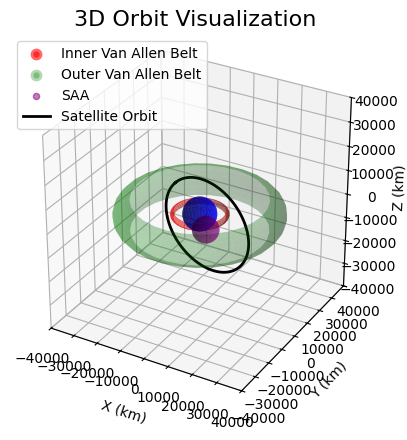

In [42]:
# Create Figure
fig_orbit = plt.figure()
ax_orbit = fig_orbit.add_subplot(111, projection='3d')
ax_orbit.set_box_aspect([1.0, 1.0, 1.0])
plot_3DObjects()
fig_orbit.canvas.draw()  # one full render
orbit_bg = fig_orbit.canvas.copy_from_bbox(fig_orbit.bbox)
plot_orbit()
orbit_line.set_data(x, y)
orbit_line.set_3d_properties(z)
fig_orbit.canvas.draw_idle()

In [43]:
# Insert the Figure in the Panel 1
canvas_orbit = FigureCanvasTkAgg(fig_orbit, master=frames[0][0])
canvas_orbit.get_tk_widget().pack(fill=tk.BOTH, expand=True)

---

## Panel 4: Orbital Parameters

In [44]:
parameters_frame = frames[1][0]
param_label = tk.Label(parameters_frame, text="Orbital Parameters", font=("Arial", 16))
param_label.pack(pady=10)

In [45]:
# Orbital parameter sliders
global param_sliders
param_sliders = {}
params = {"Semi-major axis":"km", "Eccentricity":" ", "Inclination":"°", "Longitude of ascending node":"°", "Argument of periapsis":"°", "Solar Activity Phase":"years"}

In [46]:
for param, unit in params.items():
    frame = tk.Frame(parameters_frame)
    frame.pack(fill=tk.X, padx=5, pady=10)
    
    # Sub frame for label and value 
    label_value_frame = tk.Frame(frame)
    label_value_frame.pack(fill=tk.X)
    
    label = tk.Label(label_value_frame, text=f"{param}:", font=("Arial", 14))
    label.pack(side=tk.LEFT)
    
    # Entry field for parameter value
    entry = tk.Entry(label_value_frame, font=("Arial", 14), width=8, justify="right")
    entry.pack(side=tk.LEFT, padx=5)

    # Label for units
    unit_label = tk.Label(label_value_frame, text=unit, font=("Arial", 14))
    unit_label.pack(side=tk.LEFT)

    # Slider for parameter
    slider = ttk.Scale(frame, from_=0, to=100, orient=tk.HORIZONTAL, length=300)
    slider.pack(fill=tk.X, padx=5, pady=5)
    slider.set(25)


    # Function to synchronize slider to entry
    def sync_slider_to_entry(event=None, param=param):
        """Update the entry when the slider is moved."""
        value = get_converted_slider_value(param)
        param_sliders[param]["entry"].delete(0, tk.END)
        param_sliders[param]["entry"].insert(0, f"{value:.2f}")
        if (param=="Solar Activity Phase"):
            update_solar_flux()
        else:
            update_orbit()
        update_radiation()
        update_basicslabels()

    # Function to synchronize entry to slider
    def sync_entry_to_slider(event=None, param=param):
        """Update the slider when a new value is entered."""
        try:
            value = get_value_for_slider(param)
            param_sliders[param]["slider"].set(value)
        except ValueError:
            # If input is invalid, reset entry to current slider value
            current_value = get_converted_slider_value(param)
            param_sliders[param]["entry"].delete(0, tk.END)
            param_sliders[param]["entry"].insert(0, f"{current_value:.2f}")
        if (param=="Solar Activity Phase"):
            update_solar_flux()
        else:
            update_orbit()
        update_radiation()
        update_basicslabels()
    
    # Bind events
    slider.bind("<B1-Motion>", sync_slider_to_entry)
    slider.bind("<ButtonRelease-1>", update_all)
    entry.bind("<Return>", sync_entry_to_slider)

    # Initialize the entry with the slider's starting value
    entry.insert(0, f"{slider.get():.2f}")

    # Add the slider and entry to the dictionary
    param_sliders[param] = {"slider": slider, "entry": entry}

In [47]:
Period_label = tk.Label(parameters_frame, text=f"Orbital period P: NaN day(s)", font=("Arial", 14), fg="black")
Period_label.pack(pady=10)

print_Period()

---
## Panel 5: Solar Flux vs. Solar Cycle

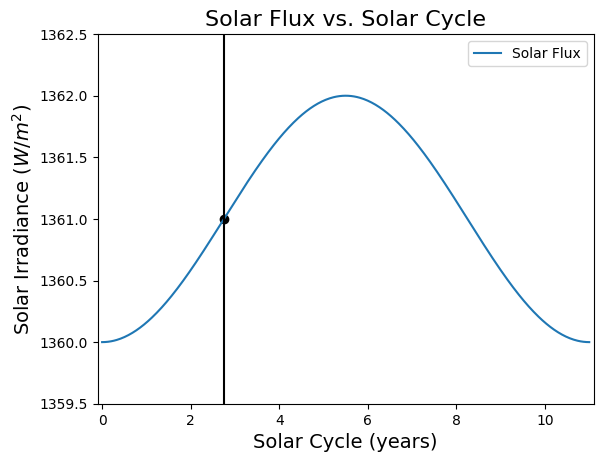

In [48]:
fig_solar_flux = plt.figure()
ax_solar_flux = fig_solar_flux.add_subplot(111)
plot_solar_flux()

In [49]:
canvas_solar_flux = FigureCanvasTkAgg(fig_solar_flux, master=frames[1][1])
canvas_solar_flux.get_tk_widget().pack(fill=tk.BOTH, expand=True)

---

## Panel 3: Radiation vs. Orbital Phase

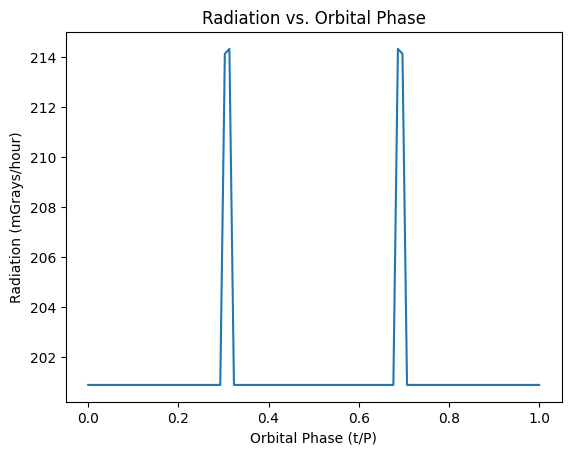

In [50]:
fig_radiation = plt.figure()
ax_radiation = fig_radiation.add_subplot(111)
plot_radiation()

In [51]:
canvas_radiation = FigureCanvasTkAgg(fig_radiation, master=frames[0][1])
canvas_radiation.get_tk_widget().pack(fill=tk.BOTH, expand=True)

---

## Panel 6: Satellite Properties

In [52]:
protection_frame = frames[1][2]
protection_label = tk.Label(protection_frame, text="Satellite characteristics", font=("Arial", 18))
protection_label.pack(pady=5)

In [53]:
label_Satsize_frame = tk.Frame(protection_frame)
label_Satsize_frame.pack(fill=tk.X)

label_Satsize = tk.Label(label_Satsize_frame, text=f"Size: 1m x 1m x 1m", font=("Arial", 16), fg="black")
label_Satsize.pack(side=tk.LEFT)

In [54]:
label_Satmass_frame = tk.Frame(protection_frame)
label_Satmass_frame.pack(fill=tk.X)

label_Satmass = tk.Label(label_Satmass_frame, text=f"Mass (without shielding): 200kg", font=("Arial", 16), fg="black")
label_Satmass.pack(side=tk.LEFT)

In [55]:
label_TIDperOrbit_frame = tk.Frame(protection_frame)
label_TIDperOrbit_frame.pack(fill=tk.X)

label_TIDperOrbit = tk.Label(label_TIDperOrbit_frame, text=f"Total Ionizing Dose (TID) per orbit: NaN Grays", font=("Arial", 16), fg="black")
label_TIDperOrbit.pack(side=tk.LEFT)

In [56]:
label_DDperOrbit_frame = tk.Frame(protection_frame)
label_DDperOrbit_frame.pack(fill=tk.X)

label_DDperOrbit = tk.Label(label_DDperOrbit_frame, text=f"Displacement Damage (DD) per orbit: NaN MeV/g", font=("Arial", 16), fg="black")
label_DDperOrbit.pack(side=tk.LEFT)

In [57]:
# Sub frame for label and value 
label_value_frame_protection = tk.Frame(protection_frame)
label_value_frame_protection.pack(fill=tk.X)

label_protection = tk.Label(label_value_frame_protection, text="Shielding thickness:", font=("Arial", 16))
label_protection.pack(side=tk.LEFT)

In [58]:
# Entry field for parameter value
entry_protection = tk.Entry(label_value_frame_protection, font=("Arial", 16), width=8, justify="right")
entry_protection.pack(side=tk.LEFT, padx=5)

In [59]:
# Label for units
unit_label = tk.Label(label_value_frame_protection, text="mm", font=("Arial", 16))
unit_label.pack(side=tk.LEFT)

In [60]:
# Slider for parameter
slider_protection = ttk.Scale(protection_frame, from_=0, to=1000, orient=tk.HORIZONTAL, length=300)
slider_protection.pack(fill=tk.X, padx=5, pady=5)
slider_protection.set(10)

In [61]:
# Function to synchronize slider to entry
def sync_slider_to_entry_protection(event=None):
    """Update the entry when the slider is moved."""
    value = param_sliders["Shielding thickness"]["slider"].get()/10.
    param_sliders["Shielding thickness"]["entry"].delete(0, tk.END)
    param_sliders["Shielding thickness"]["entry"].insert(0, f"{value:.2f}")

In [62]:
# Function to synchronize entry to slider
def sync_entry_to_slider_protection(event=None):
    """Update the slider when a new value is entered."""
    try:
        value = float(param_sliders["Shielding thickness"]["entry"].get())*10.
        param_sliders["Shielding thickness"]["slider"].set(value)
    except ValueError:
        # If input is invalid, reset entry to current slider value
        current_value = param_sliders["Shielding thickness"]["slider"].get()/10.
        param_sliders["Shielding thickness"]["entry"].delete(0, tk.END)
        param_sliders["Shielding thickness"]["entry"].insert(0, f"{current_value:.2f}")
    update_tid_DD()

In [63]:
# Bind events
slider_protection.bind("<B1-Motion>", sync_slider_to_entry_protection)
slider_protection.bind("<ButtonRelease-1>", update_tid_DD)
entry_protection.bind("<Return>", sync_entry_to_slider_protection)

'131037306008256sync_entry_to_slider_protection'

In [64]:
# Initialize the entry with the slider's starting value
entry_protection.insert(0, f"{slider.get():.2f}")

In [65]:
# Add the slider and entry to the dictionary
param_sliders["Shielding thickness"] = {"slider": slider_protection, "entry": entry_protection}

In [66]:
label_TIDperOrbit_protected_frame = tk.Frame(protection_frame)
label_TIDperOrbit_protected_frame.pack(fill=tk.X)

label_TIDperOrbit_protected = tk.Label(label_TIDperOrbit_protected_frame, text=f"TID per Orbit after shielding: NaN Grays", font=("Arial", 16), fg="black")
label_TIDperOrbit_protected.pack(side=tk.LEFT)

In [67]:
label_DDperOrbit_protected_frame = tk.Frame(protection_frame)
label_DDperOrbit_protected_frame.pack(fill=tk.X)

label_DDperOrbit_protected = tk.Label(label_DDperOrbit_protected_frame, text=f"DD per orbit after shielding: NaN MeV/g", font=("Arial", 16), fg="black")
label_DDperOrbit_protected.pack(side=tk.LEFT)

In [68]:
# Material Frame
global selected_material
selected_material = tk.StringVar(value="None")

In [69]:
material_frame = tk.Frame(protection_frame)
material_frame.pack(fill=tk.X)

label_material = tk.Label(material_frame, text="Select material for shielding", font=("Arial", 16))
label_material.pack(side=tk.LEFT)

In [70]:
# Conditional checkbox Aluminium
protection_Aluminium = tk.Radiobutton(
    material_frame, text="Aluminium shielding", font=("Arial", 16),
    variable=selected_material, value="Aluminium", command=update_material
)
protection_Aluminium.pack(anchor="w", padx=10)

In [71]:
# Conditional checkbox Polyethylene
protection_polyethylene = tk.Radiobutton(
    material_frame, text="Polyethylene shielding", font=("Arial", 16),
    variable=selected_material, value="Polyethylene", command=update_material
)
protection_polyethylene.pack(anchor="w", padx=10)

In [72]:
# Conditional checkbox Composite
protection_composite = tk.Radiobutton(
    material_frame, text="Composite shielding", font=("Arial", 16),
    variable=selected_material, value="Composite", command=update_material
)
protection_composite.pack(anchor="w", padx=10)

In [73]:
label_Satmass_shield_frame = tk.Frame(protection_frame)
label_Satmass_shield_frame.pack(fill=tk.X)

label_Satmass_shield = tk.Label(label_Satmass_shield_frame, text=f"Total mass (with shielding): 200 kg", font=("Arial", 16), fg="black")
label_Satmass_shield.pack(side=tk.LEFT)

In [74]:
label_SatLaunchcost_frame = tk.Frame(protection_frame)
label_SatLaunchcost_frame.pack(fill=tk.X)

label_SatLaunchcost = tk.Label(label_SatLaunchcost_frame, text=f"Launching Cost (+ shielding): $2,000,000 + $0", font=("Arial", 16), fg="black")
label_SatLaunchcost.pack(side=tk.LEFT)

In [75]:
label_SatShieldingcost_frame = tk.Frame(protection_frame)
label_SatShieldingcost_frame.pack(fill=tk.X)

label_SatShieldingcost = tk.Label(label_SatShieldingcost_frame, text=f"Shielding Cost: $0", font=("Arial", 16), fg="black")
label_SatShieldingcost.pack(side=tk.LEFT)

In [76]:
separator = ttk.Separator(protection_frame, orient="horizontal")
separator.pack(fill="x", padx=10, pady=5)

In [77]:
label_SatTotalcost_frame = tk.Frame(protection_frame)
label_SatTotalcost_frame.pack(fill=tk.X)

label_SatTotalcost = tk.Label(label_SatTotalcost_frame, text=f"Total Cost: $2,000,000", font=("Arial", 18), fg="red")
label_SatTotalcost.pack(side=tk.LEFT)

---

## Panel 5: TID & DD vs. Time

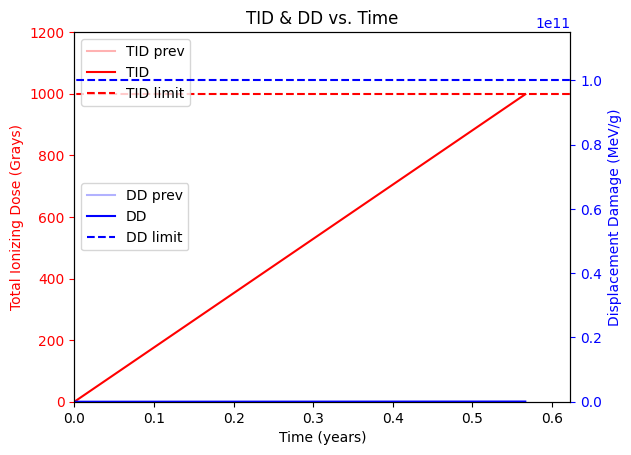

In [78]:
fig_tid = plt.figure()
ax_tid = fig_tid.add_subplot(111)
ax_dd = ax_tid.twinx()

global time_prev, TIDvsTime_prev, DDvsTime_prev
# initiate previous curve for comparison
time_prev = [0.]
TIDvsTime_prev = [0.]
DDvsTime_prev = [0.]

plot_tid_DD()

In [79]:
canvas_tid = FigureCanvasTkAgg(fig_tid, master=frames[0][2])
canvas_tid.get_tk_widget().pack(fill=tk.BOTH, expand=True)

In [80]:
# update the entry from slider values
initialize_entries()

In [ ]:
# Run the application
root.mainloop()

[update_orbit] execution time = 1.04 ms
[update_orbit] execution time = 0.13 ms
[update_orbit] execution time = 0.13 ms
[update_orbit] execution time = 0.13 ms
[update_orbit] execution time = 0.17 ms
[update_orbit] execution time = 0.15 ms
[update_orbit] execution time = 1.00 ms
[update_orbit] execution time = 0.42 ms
[update_orbit] execution time = 0.16 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.15 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.13 ms
[update_orbit] execution time = 1.03 ms
[update_orbit] execution time = 0.17 ms
[update_orbit] execution time = 0.12 ms
[update_orbit] execution time = 0.50 ms
[update_orbit] execution time = 1.42 ms
[update_orbit] execution time = 0.13 ms
